In [54]:
import csv

import nltk
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [55]:
LEXICON_FILE_PATH = "./lexica/connotation_lexicon_a.0.1.csv"
TRAINING_FILE_PATH = "./data/train.jsonl"
PRO_SENTIMENT_SCORE = 'pro_sentiment_score'
CON_SENTIMENT_SCORE = 'con_sentiment_score'
USER_FEATURE_1 = 'user_feature_1'
USER_FEATURE_2 = 'user_feature_2'
LIG_FEATURE_1 = 'lig_feature_1'
LIG_FEATURE_2 = 'lig_feature_2'
PRO_TEXT = 'pro_text'
CON_TEXT = 'con_text'
CATEGORY = 'category'
RELIGION = 'Religion'
WINNER = 'winner'
ROUNDS = 'rounds'
TEXT = 'text'
SIDE = 'side'
PRO = 'Pro'
CON = 'Con'

In [56]:
def get_debate_data(training_file_path, lexicon_file_path):
    data = pd.read_json(training_file_path, lines=True)
    religious_debate_data = pd.DataFrame()
    non_religious_debate_data = pd.DataFrame()

    lexicon = get_lexicon(lexicon_file_path)

    for debate in data.iterrows():
        if debate[1][CATEGORY] == RELIGION:
            religious_debate_data = religious_debate_data.append(get_data(debate, lexicon), ignore_index=True)
        else:
            non_religious_debate_data = non_religious_debate_data.append(get_data(debate, lexicon), ignore_index=True)

    return religious_debate_data, non_religious_debate_data


def get_lexicon(lexicon_file_path):
    file = open(lexicon_file_path)
    csvreader = csv.reader(file)
    lexicon = {}
    for row in csvreader:
        word = row[0].split('_')
        sentiment = get_score(row[1])
        if word[0] not in lexicon.keys():
            lexicon[word[0]] = []
        lexicon[word[0]].append(sentiment)

    return lexicon


def get_pos(text):
    token = nltk.word_tokenize(text.lower())
    return nltk.pos_tag(token)


def get_sentiment_score(text, lexicons):
    sentiment = 0
    count = 0
    for word in text.split(" "):
        if word in lexicons.keys():
            sentiment += sum(lexicons[word]) / len(lexicons[word])
            count += 1

    if count == 0:
        return 0
    return sentiment / count


def get_score(sentiment):
    if sentiment == 'negative':
        return -1
    elif sentiment == 'positive':
        return 1
    return 0


def get_data(debate, lexicon):
    winner = debate[1][WINNER]
    pro = ''
    con = ''
    for round in debate[1][ROUNDS]:
        for turn in round:
            if turn[SIDE] == PRO:
                pro += turn[TEXT]
            elif turn[SIDE] == CON:
                con += turn[TEXT]

    pro_sentiment_score = get_sentiment_score(pro, lexicon)
    con_sentiment_score = get_sentiment_score(con, lexicon)

    return {PRO_TEXT: pro, CON_TEXT: con, WINNER: winner, PRO_SENTIMENT_SCORE: pro_sentiment_score,
            CON_SENTIMENT_SCORE: con_sentiment_score}

In [57]:
def get_ngrams(data_train, data_test, k):
    vectorizer = TfidfVectorizer(lowercase=True, stop_words={'english'}, ngram_range=(1, 2), max_features=k)
    X_train_ngrams = vectorizer.fit_transform(data_train)
    X_test_ngrams = vectorizer.transform(data_test)
    return X_train_ngrams, X_test_ngrams


def get_features(data_train, data_test, k, model="Ngrams"):
    X_train, X_test = csr_matrix((len(data_train), 0), dtype=np.int8), csr_matrix((len(data_test), 0), dtype=np.int8)

    if "Ngram" in model:
        pro_train_ngrams, pro_test_ngrams = get_ngrams(data_train[PRO_TEXT], data_test[PRO_TEXT], k)
        con_train_ngrams, con_test_ngrams = get_ngrams(data_train[CON_TEXT], data_test[CON_TEXT], k)
        X_train = hstack([X_train, pro_train_ngrams, con_train_ngrams])
        X_test = hstack([X_test, pro_test_ngrams, con_test_ngrams])

    if "+Lex" in model:
        X_train = hstack(
            [X_train, csr_matrix(data_train[PRO_SENTIMENT_SCORE]).T, csr_matrix(data_train[CON_SENTIMENT_SCORE]).T])
        X_test = hstack(
            [X_test, csr_matrix(data_test[PRO_SENTIMENT_SCORE]).T, csr_matrix(data_test[CON_SENTIMENT_SCORE]).T])

    return X_train, X_test


def fit_predict_report_model(features_train, labels_train, features_test, labels_test, c):
    model = LogisticRegression(C=c, penalty='l2', solver='newton-cg')

    model.fit(features_train, labels_train)
    labels_predicted = model.predict(features_test)

    print('Logistic Classification report:')
    print(classification_report(labels_test, labels_predicted))
    print("Accuracy score: ", accuracy_score(labels_test, labels_predicted))
    plot_confusion_matrix(model, features_test, labels_test)


def pipeline(training_data, test_data, k, c, model):
    train, test = get_features(training_data, test_data, k, model)
    fit_predict_report_model(train, training_data['winner'], test, test_data['winner'], c)

Religious Debates with Ngram+Lex
Logistic Classification report:
              precision    recall  f1-score   support

         Con       0.62      0.92      0.74        39
         Pro       0.81      0.37      0.51        35

    accuracy                           0.66        74
   macro avg       0.72      0.65      0.63        74
weighted avg       0.71      0.66      0.63        74

Accuracy score:  0.6621621621621622
---------------------------------------------------
Non Religious Debates with Ngram+Lex
Logistic Classification report:
              precision    recall  f1-score   support

         Con       0.68      0.92      0.78       132
         Pro       0.85      0.50      0.63       113

    accuracy                           0.73       245
   macro avg       0.77      0.71      0.71       245
weighted avg       0.76      0.73      0.71       245

Accuracy score:  0.726530612244898


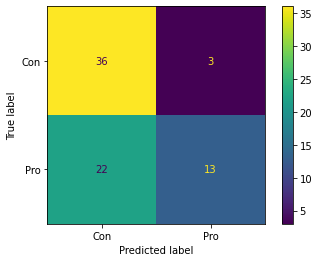

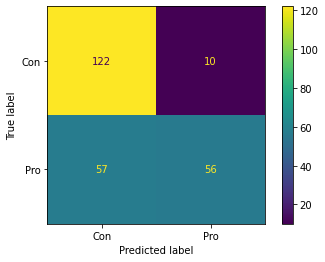

In [58]:
print("Religious Debates with Ngram+Lex")
train_religious_debate_data, non_religious_debate_data = get_debate_data(TRAINING_FILE_PATH, LEXICON_FILE_PATH)
train_religious_debate_data, test_religious_debate_data = train_test_split(religious_debate_data, test_size=0.2,
                                                                               random_state=42)
pipeline(train_religious_debate_data, test_religious_debate_data, 2000, 10, "Ngram+Lex")

print("---------------------------------------------------")
print("Non Religious Debates with Ngram+Lex")
train_non_religious_debate_data, test_non_religious_debate_data = train_test_split(non_religious_debate_data,
                                                                                       test_size=0.2, random_state=55)
pipeline(train_non_religious_debate_data, test_non_religious_debate_data, 5000, 1, "Ngram+Lex")

Religious Debates
Logistic Classification report:
              precision    recall  f1-score   support

         Con       0.62      0.92      0.74        39
         Pro       0.81      0.37      0.51        35

    accuracy                           0.66        74
   macro avg       0.72      0.65      0.63        74
weighted avg       0.71      0.66      0.63        74

Accuracy score:  0.6621621621621622
---------------------------------------------------
Non Religious Debates with Ngram+Lex
Logistic Classification report:
              precision    recall  f1-score   support

         Con       0.68      0.93      0.79       132
         Pro       0.86      0.50      0.63       113

    accuracy                           0.73       245
   macro avg       0.77      0.71      0.71       245
weighted avg       0.77      0.73      0.72       245

Accuracy score:  0.7306122448979592


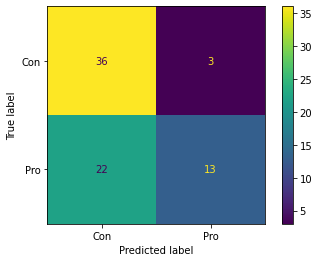

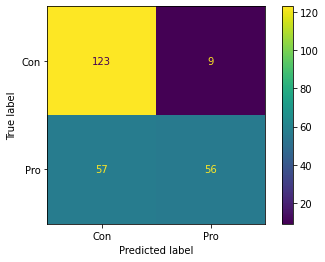

In [60]:
print("Religious Debates with Ngram"")
train_religious_debate_data, test_religious_debate_data = train_test_split(religious_debate_data, test_size=0.2,
                                                                               random_state=42)
pipeline(train_religious_debate_data, test_religious_debate_data, 2000, 10, "Ngram")

print("---------------------------------------------------")
print("Non Religious Debates with Ngram")
train_non_religious_debate_data, test_non_religious_debate_data = train_test_split(non_religious_debate_data,
                                                                                       test_size=0.2, random_state=55)
pipeline(train_non_religious_debate_data, test_non_religious_debate_data, 5000, 1, "Ngram")

In [64]:
test_data = pd.read_json("./data/val.jsonl", lines=True)

In [66]:
test_data['winner']

0      Pro
1      Pro
2      Con
3      Pro
4      Pro
      ... 
394    Pro
395    Con
396    Pro
397    Con
398    Con
Name: winner, Length: 399, dtype: object

In [78]:
with open('./output.txt') as f:
    lines = f.read().splitlines()

lines[0]

'Pro'

In [79]:
accuracy_score(test_data['winner'], lines)

0.7619047619047619

In [91]:
TRAIN_RELIGIOUS_DATA_FILE = './test_religious_data_file.pkl'
df = pd.read_pickle(TRAIN_RELIGIOUS_DATA_FILE)

In [92]:
PRO_DEBATE_LENGTH = 'pro_debate_length'
CON_DEBATE_LENGTH = 'con_debate_length'
WINNER = 'winner'

length_of_debate = []
winner = []

for debate in df.iterrows():
    length_of_debate.append(debate[1][PRO_DEBATE_LENGTH] - debate[1][CON_DEBATE_LENGTH])
    winner.append(1 if debate[1][WINNER] == 'Pro' else 0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  """


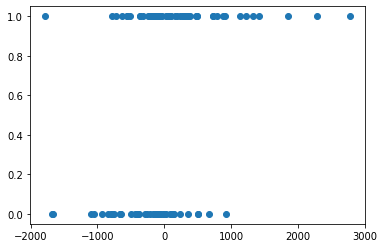

In [94]:
import matplotlib
import matplotlib.pyplot as plt
plt.scatter(length_of_debate, winner)
plt.show()